# ORIGINAL PROBLEM FORMULATION

In [1]:
# defining the libraries to be used
import gurobipy as gp
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# INFORMATION NEEDED FOR PROBLEM FORMULATION

# list of teams in the NFL (without Seattle)
teams = ["Arizona Cardinals","Atlanta Falcons","Baltimore Ravens","Buffalo Bills","Carolina Panthers","Chicago Bears",
         "Cincinnati Bengals","Cleveland Browns","Dallas Cowboys","Denver Broncos","Detroit Lions","Green Bay Packers",
         "Houston Texans","Indianapolis Colts","Jacksonville Jaguars","Kansas City Chiefs","Las Vegas Raiders",
         "Los Angeles Chargers","Los Angeles Rams","Miami Dolphins","Minnesota Vikings","New England Patriots",
         "New Orleans Saints","New York Giants","New York Jets","Philadelphia Eagles","Pittsburgh Steelers",
         "San Francisco 49ers","Tampa Bay Buccaneers","Tennessee Titans","Washington Football Team"]

viewership_not_used=np.array([
                    [9.23,0,0,0,0,0,18.94],
                    [15.59,0,0,6.68,0,0,17.69],
                    [14.7,0,0,5.43,0,0,17.8],
                    [8.65,0,0,5.41,0,0,15.08],
                    [10.69,0,0,14.71,0,0,15.08],
                    [11.32,0,0,12.16,0,0,12.6],
                    [10.91,0,0,10.07,0,0,14.31],
                    [11.7,0,0,11.68,0,0,16.93],
                    [10.22,0,0,13.17,0,0,16.88],
                    [11.45,0,0,12.16,0,0,15.79],
                    [12.61,0,0,14.77,0,0,19.57],
                    [11.38,0,0,27.16,0,0,16.48],
                    [14.17,0,0,13.54,0,0,17.07],
                    [11.39,0,0,13.64,0,0,17.05],
                    [12.72,0,0,12.96,0,0,15.61],
                    [14.45,0,0,0,0,6.44,18.37],
                    [0,0,0,0,0,0,16.55],
                    [0,0,0,0,0,24.62,27.16]])

# Teams in each conference based off of the team name's index from the "teams" list
AFC = [2,3,6,7,9,12,13,14,15,16,17,19,21,24,26,29]
NFC = [0,1,4,5,8,10,11,18,20,22,23,25,27,28,30] # seattle is in this conference

# Teams in each division based off of the team name's index from the "teams" list
AFC_East = [3,19,21,24]
AFC_North = [2,6,7,26]
AFC_South = [12,13,14,29]
AFC_West = [9,15,16,17]
NFC_East = [8,23,25,30]
NFC_North = [5,10,11,20]
NFC_South = [1,4,22,28]
NFC_West = [0,18,27] # seattle is in this division
NFC_all=[1,4,5,8,10,11,20,22,23,25,28,30] # list of all teams in the NFC besides teams in the NFC West


days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
number_days = len(days_of_week)
number_teams = len(teams)
number_weeks = 18
number_games = 17

In [3]:
# Defining the model
model = gp.Model("Seattle Seahawks Schedule")

Academic license - for non-commercial use only - expires 2022-10-04
Using license file C:\Users\crist\gurobi.lic


In [4]:
# DEFINING THE DECISION VARIABLES

# Games played on week i and day j
x = model.addVars(number_weeks,number_days,vtype=GRB.BINARY, name=["Week "+str(i+1)+" on "+j for i in range(number_weeks) for j in days_of_week])

# Game is at home or not at home (can be an away game or no game happening for the bye week - hence why we say home or not home)
y = model.addVars(number_weeks, vtype=GRB.BINARY, name=["Week "+str(i+1)+" game at home" for i in range(number_weeks)])

# Game on week i against team j
z = model.addVars(number_weeks, number_teams, vtype=GRB.BINARY, name=["Week "+str(i+1)+" with team "+j for i in range(number_weeks) for j in teams])

# Number of games played against teams in the NFC North, East, and South
division=["North", "East", "South"]
N = model.addVars(3, lb=1, ub=4, vtype=GRB.INTEGER, name=["NFC "+i for i in division])

# Number of games played against teams in the AFC North, East, South, West
division2=["North", "East", "South", "West"]
A = model.addVars(4, lb=0, ub=4, vtype=GRB.INTEGER, name=["AFC "+i for i in division2])

# Dummy variable for NFC games
t = model.addVars(3, vtype=GRB.BINARY)

# Dummy for AFC games
s = model.addVars(4, vtype=GRB.BINARY)

In [5]:
# SETTING THE OBJECTIVE FUNCTION - maximize number of games
games=sum(x[i,j] for i in range(number_weeks) for j in range(number_days))
model.setObjective(games, GRB.MAXIMIZE)

In [6]:
# DEFINING THE CONSTRAINTS

### CONSTRAINTS INVOLVING THE NUMBER OF GAMES
# Can only play 1 game a week - needs to be defined for both xij and zij
for i in range(number_weeks):
    model.addConstr(sum(x[i,j] for j in range(number_days))<=1)
    model.addConstr(sum(z[i,j] for j in range(number_teams))<=1)

# 1 week off for bye-week any time between weeks 6 and 14 inclusive - the sum of all the games from weeks 6-14 should be equal to 8
byeweek=sum(x[i,j] for i in range(5,14) for j in range(number_days))
model.addConstr(byeweek==8)

# There are 17 games in a season - needs to be defined for both xij and zij
sumgames=sum(x[i,j] for i in range(number_weeks) for j in range(number_days))
model.addConstr(sumgames==17)

sumgames2=sum(z[i,j] for i in range(number_weeks) for j in range(number_teams))
model.addConstr(sumgames2==17)

# If there is a game during the week of xij, then there should be a game during zij (to co-inside with the bye week)
for i in range(number_weeks):
    model.addConstr(sum(z[i,j] for j in range(number_teams))==sum(x[i,j] for j in range(number_days)))

    
### CONSTRAINTS INVOLVING GAMES THAT CAN BE PLAYED ON SPECIFIC DAYS OF THE WEEK
# Games are on Mondays, Thursdays, or Sundays, with the exception that weeks 15,16, and 18 have an additional option for Saturdays
play_days=[0,3,6] # can play on mondays, thursdays, and sundays
no_play_days=[1,2,4] # can't play on tuesdays, wednesdays, and fridays
saturday_no_play_weeks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,16] # can't play on saturdays during these weeks

# Can't play on Tuesdays, Wednesdays, and Fridays
for i in no_play_days:
    model.addConstr(sum(x[j,i] for j in range(number_weeks))==0)

# Can't play on Saturdays during weeks 1-14, and week 17
for i in saturday_no_play_weeks:
    model.addConstr(x[i,5]==0)
    
# If the team plays on Sunday on week i, they cannot play on Monday week i+1 (avoid back to back games)
for i in range(1,number_weeks):
    model.addConstr(x[i,0]+x[i-1,6]<=1)    
    
# 1 Monday in the schedule
model.addConstr(sum(x[i,0] for i in range(number_weeks))==1)

# 1 Thursday in the schedule
model.addConstr(sum(x[i,3] for i in range(number_weeks))==1)  

# Maximum 1 Saturday game
model.addConstr(sum(x[i,5] for i in range(number_weeks))<=1) 

# If the team plays on Saturday on week i, they cannot play on Monday week i+1 (avoid back to back games)
for i in range(1,number_weeks):
    model.addConstr(x[i,0]+x[i-1,5]<=1)   


### CONSTRAINTS INVOLVING HOME/AWAY GAMES
# There is a total of 8 home games in a regular season
model.addConstr(sum(y[i] for i in range(number_weeks))==8)

# There should not be more than 2 back-to-back away games in the season, meaning that within 3 weeks, the sum of yi should be at minimum equal to 1 home game
for i in range(number_weeks-2):
    model.addConstr(y[i]+y[i+1]+y[i+2]>=1)

# If there is a game on xij then the game is either home/away
for i in range(number_weeks):
    model.addConstr(y[i]<=sum(x[i,j] for j in range(number_days)))

    
### CONSTRAINTS INVOLVING PLAYING TEAMS IN THE VARIOUS DIVISIONS AND CONFERENCES    
# Must have 2 games per team in the same division (NFC West)
for i in NFC_West:
    model.addConstr(sum(z[j,i] for j in range(number_weeks))==2)

## Must have 6 games against teams in the same NFC conference (but not including the NFC West division). 4 must be with 1 division, 1 with another division, and 1 with another division     
# Total number of games with all NFC divisions other than the NFC West must equal to 6
model.addConstr(N[0]+N[1]+N[2]==6)

# If the division is North, then the sum of the North division games should be equal to total number of games to be played in the North division
sumNFCNorth = sum(z[i,j] for i in range(number_weeks) for j in NFC_North)
model.addConstr(sumNFCNorth==N[0]) 

# If the division is East, then the sum of the East division games should be equal to total number of games to be played in the East division
sumNFCEast = sum(z[i,j] for i in range(number_weeks) for j in NFC_East)
model.addConstr(sumNFCEast==N[1])

# If the division is South, then the sum of the South division games should be equal to total number of games to be played in the South division
sumNFCSouth = sum(z[i,j] for i in range(number_weeks) for j in NFC_South)
model.addConstr(sumNFCSouth==N[2])

# Applying the N possible Values method to determine which combination of games should be given to each division
# 4 games must be within 1 division conference, 1 game with another division conference, and 1 game with another division
model.addConstr(N[0]==1*t[0]+1*t[1]+4*t[2])
model.addConstr(N[1]==1*t[0]+4*t[1]+1*t[2])
model.addConstr(N[2]==4*t[0]+1*t[1]+1*t[2])
model.addConstr(t[0]+t[1]+t[2]==1)    
    
# Can't play the same team twice from these divisions
for j in NFC_all:
    model.addConstr(sum(z[i,j] for i in range(number_weeks))<=1)
    

## Must have 5 games against divisions in the AFC conference. 4 must be with 1 division, 1 must be with another division
# Total number of games with all AFC divisions must equal to 5
model.addConstr(A[0]+A[1]+A[2]+A[3]==5)

# If the division is North, then the sum of the North division games should be equal to total number of games to be played in the North division
sumAFCNorth = sum(z[i,j] for i in range(number_weeks) for j in AFC_North)
model.addConstr(sumAFCNorth==A[0])

# If the division is East, then the sum of the East division games should be equal to total number of games to be played in the East division
sumAFCEast = sum(z[i,j] for i in range(number_weeks) for j in AFC_East)
model.addConstr(sumAFCEast==A[1])

# If the division is South, then the sum of the South division games should be equal to total number of games to be played in the South division
sumAFCSouth = sum(z[i,j] for i in range(number_weeks) for j in AFC_South)
model.addConstr(sumAFCSouth==A[2])

# If the division is West, then the sum of the West division games should be equal to total number of games to be played in the West division
sumAFCWest = sum(z[i,j] for i in range(number_weeks) for j in AFC_West)
model.addConstr(sumAFCWest==A[3])

# Applying the big M method to determine which division will have 4 games
M = 9999999
model.addConstr(A[0]>=4-M*s[0])
model.addConstr(A[1]>=4-M*s[1])
model.addConstr(A[2]>=4-M*s[2])
model.addConstr(A[3]>=4-M*s[3])
model.addConstr(s[0]+s[1]+s[2]+s[3]==3)

# Can't play the same team twice from the AFC
for j in AFC:
    model.addConstr(sum(z[i,j] for i in range(number_weeks))<=1)


In [7]:
# optimizing the model
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 196 rows, 716 columns and 3619 nonzeros
Model fingerprint: 0x82562355
Variable types: 0 continuous, 716 integer (709 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 41 rows and 75 columns
Presolve time: 0.02s
Presolved: 155 rows, 641 columns, 2591 nonzeros
Variable types: 0 continuous, 641 integer (637 binary)

Root relaxation: objective 1.700000e+01, 77 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17.00000    0    2          -   17.00000      -     -    0s
H    0     0                      17.0000000   17.00000  0.00%     -    0s

Explored 1 nodes (77 simp

In [8]:
# getting the variables
for v in model.getVars():
    if v.x !=0:
        print(v.varName, "=", round(v.x,2))

Week 1 on Sunday = 1.0
Week 2 on Sunday = 1.0
Week 3 on Thursday = 1.0
Week 4 on Monday = 1.0
Week 5 on Sunday = 1.0
Week 6 on Sunday = 1.0
Week 7 on Sunday = 1.0
Week 9 on Sunday = 1.0
Week 10 on Sunday = 1.0
Week 11 on Sunday = 1.0
Week 12 on Sunday = 1.0
Week 13 on Sunday = 1.0
Week 14 on Sunday = 1.0
Week 15 on Sunday = 1.0
Week 16 on Sunday = 1.0
Week 17 on Sunday = 1.0
Week 18 on Sunday = 1.0
Week 1 game at home = 1.0
Week 4 game at home = 1.0
Week 6 game at home = 1.0
Week 7 game at home = 1.0
Week 10 game at home = 1.0
Week 11 game at home = 1.0
Week 13 game at home = 1.0
Week 16 game at home = 1.0
Week 1 with team Los Angeles Rams = 1.0
Week 2 with team Arizona Cardinals = 1.0
Week 3 with team Tampa Bay Buccaneers = 1.0
Week 4 with team Cincinnati Bengals = 1.0
Week 5 with team Los Angeles Rams = 1.0
Week 6 with team Green Bay Packers = 1.0
Week 7 with team Kansas City Chiefs = 1.0
Week 9 with team Las Vegas Raiders = 1.0
Week 10 with team Atlanta Falcons = 1.0
Week 11 with te

In [9]:
# creating a numpy array
numpyArray = np.empty((18, 7),dtype = str)
  
# generating the Pandas dataframe
# from the Numpy array and specifying
# name of index and columns
weeksList=[]
for i in range(18):
    weeksList.append("Week "+str(i+1))
panda_df = pd.DataFrame(data = numpyArray, 
                        index = weeksList, 
                        columns = days_of_week)
  
# Getting the weeks and the game days to create a new Dataframe
counter=0
game_day_position={}
game_day_position_home={}
playing_team = {}
for v in model.getVars():
    if v.x !=0:
        counter=counter+1
        if(counter<18):
            a=v.varName
            day_var=a.split()[3]
            week_var=a.split()[0]+" "+a.split()[1]
            game_day_position[week_var]=day_var

        if(counter>=18 and counter<=25):
            a=v.varName
            week_var=a.split()[0]+" "+a.split()[1]
            game_day_position_home[week_var]=game_day_position[week_var]
        
        if(counter>25 and counter<=42):
            a=v.varName
            week_var=a.split()[0]+" "+a.split()[1]
            teamName=a.split(" team ")[1]
            playing_team[week_var]=teamName
panda_df['Team']=''

#adding the opponent team names in the dataframe
for i in playing_team.keys():
    panda_df.loc[i]['Team']=playing_team[i]

diffKeys = set(game_day_position.keys()) - set(game_day_position_home.keys())

game_day_position_away = dict()

for key in diffKeys:
    game_day_position_away[key] = game_day_position.get(key)
#getting the Home Game Days and weeks
for i in game_day_position_home:
    panda_df.loc[i][game_day_position_home[i]]='Home Game Day'
#getting the Away Game Days and weeks
for i in game_day_position_away:
    panda_df.loc[i][game_day_position_away[i]]='Away Game Day'

#highlighting the Home game days and away games separately.
def highlight_cells(x):
    df = x.copy()
    #set default color
    #df.loc[:,:] = 'background-color: papayawhip' 
    df.loc[:,:] = '' 
    for i in range(18):
        for j in range(7):
            if(x.iloc[i,j]=='Home Game Day'):
                df.iloc[i,j] = 'background-color: lightgreen'
            elif(x.iloc[i,j]=='Away Game Day'):
                df.iloc[i,j] = 'background-color: #ddeecc'
    return df 
t=panda_df.style.apply(highlight_cells, axis=None)
t

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Team
Week 1,,,,,,,Home Game Day,Los Angeles Rams
Week 2,,,,,,,Away Game Day,Arizona Cardinals
Week 3,,,,Away Game Day,,,,Tampa Bay Buccaneers
Week 4,Home Game Day,,,,,,,Cincinnati Bengals
Week 5,,,,,,,Away Game Day,Los Angeles Rams
Week 6,,,,,,,Home Game Day,Green Bay Packers
Week 7,,,,,,,Home Game Day,Kansas City Chiefs
Week 8,,,,,,,,
Week 9,,,,,,,Away Game Day,Las Vegas Raiders
Week 10,,,,,,,Home Game Day,Atlanta Falcons


In [10]:
viewership_not_used_df=pd.DataFrame(columns=days_of_week)
for i in range(0,18):
    for j in range(0,7):
        if(panda_df.iloc[i,j]==''):
            viewership_not_used[i][j]=0.0
viewership_not_used_df= (viewership_not_used_df.append(dict(zip(viewership_not_used_df.columns, np.mean(viewership_not_used, axis=0))), ignore_index=True)).T.rename(columns={0: "Model 1: Avg TV Views"})
print(viewership_not_used_df)            

           Model 1: Avg TV Views
Monday                  0.480556
Tuesday                 0.000000
Wednesday               0.000000
Thursday                0.301667
Friday                  0.000000
Saturday                0.000000
Sunday                 14.397222


# REFORMULATED PROBLEM - MAXIMIZING VIEWERSHIP

In [11]:
# NEW DATA FOR AVERAGE NFL VIEWERSHIP ON EACH DAY OF EACH WEEK
# https://www.sportsmediawatch.com/nfl-tv-ratings-viewership-2021/2/
viewership=np.array([[9.23,0,0,0,0,0,18.94],
                    [15.59,0,0,6.68,0,0,17.69],
                    [14.7,0,0,5.43,0,0,17.8],
                    [8.65,0,0,5.41,0,0,15.08],
                    [10.69,0,0,14.71,0,0,15.08],
                    [11.32,0,0,12.16,0,0,12.6],
                    [10.91,0,0,10.07,0,0,14.31],
                    [11.7,0,0,11.68,0,0,16.93],
                    [10.22,0,0,13.17,0,0,16.88],
                    [11.45,0,0,12.16,0,0,15.79],
                    [12.61,0,0,14.77,0,0,19.57],
                    [11.38,0,0,27.16,0,0,16.48],
                    [14.17,0,0,13.54,0,0,17.07],
                    [11.39,0,0,13.64,0,0,17.05],
                    [12.72,0,0,12.96,0,0,15.61],
                    [14.45,0,0,0,0,6.44,18.37],
                    [0,0,0,0,0,0,16.55],
                    [0,0,0,0,0,24.62,27.16]])

In [12]:
# Defining the model
model2 = gp.Model("Seattle Seahawks Schedule with Viewership")

In [13]:
# DEFINING THE DECISION VARIABLES

# Games played on week i and day j
x = model2.addVars(number_weeks,number_days,vtype=GRB.BINARY, name=["Week "+str(i+1)+" on "+j for i in range(number_weeks) for j in days_of_week])

# Game is at home or not at home (can be an away game or no game happening for the bye week - hence why we say home or not home)
y = model2.addVars(number_weeks, vtype=GRB.BINARY, name=["Week "+str(i+1)+" game at home" for i in range(number_weeks)])

# Game on week i against team j
z = model2.addVars(number_weeks, number_teams, vtype=GRB.BINARY, name=["Week "+str(i+1)+" with team "+j for i in range(number_weeks) for j in teams])

# Number of games played against teams in the NFC North, East, and South
division=["North", "East", "South"]
N = model2.addVars(3, lb=1, ub=4, vtype=GRB.INTEGER, name=["NFC "+i for i in division])

# Number of games played against teams in the AFC North, East, South, West
division2=["North", "East", "South", "West"]
A = model2.addVars(4, lb=0, ub=4, vtype=GRB.INTEGER, name=["AFC "+i for i in division2])

# Dummy variable for NFC games
t = model2.addVars(3, vtype=GRB.BINARY)

# Dummy for AFC games
s = model2.addVars(4, vtype=GRB.BINARY)

In [14]:
# SETTING THE OBJECTIVE FUNCTION - maximize viewership
maxview=sum(x[i,j]*viewership[i][j] for i in range(number_weeks) for j in range(number_days))
model2.setObjective(maxview, GRB.MAXIMIZE)

In [15]:
# DEFINING THE CONSTRAINTS

### CONSTRAINTS INVOLVING THE NUMBER OF GAMES
# Can only play 1 game a week - needs to be defined for both xij and zij
for i in range(number_weeks):
    model2.addConstr(sum(x[i,j] for j in range(number_days))<=1)
    model2.addConstr(sum(z[i,j] for j in range(number_teams))<=1)

# 1 week off for bye-week any time between weeks 6 and 14 inclusive - the sum of all the games from weeks 6-14 should be equal to 8
byeweek=sum(x[i,j] for i in range(5,14) for j in range(number_days))
model2.addConstr(byeweek==8)

# There are 17 games in a season - needs to be defined for both xij and zij
sumgames=sum(x[i,j] for i in range(number_weeks) for j in range(number_days))
model2.addConstr(sumgames==17)

sumgames2=sum(z[i,j] for i in range(number_weeks) for j in range(number_teams))
model2.addConstr(sumgames2==17)

# If there is a game during the week of xij, then there should be a game during zij (to co-inside with the bye week)
for i in range(number_weeks):
    model2.addConstr(sum(z[i,j] for j in range(number_teams))==sum(x[i,j] for j in range(number_days)))

    
### CONSTRAINTS INVOLVING GAMES THAT CAN BE PLAYED ON SPECIFIC DAYS OF THE WEEK
# Games are on Mondays, Thursdays, or Sundays, with the exception that weeks 15,16, and 18 have an additional option for Saturdays
play_days=[0,3,6] # can play on mondays, thursdays, and sundays
no_play_days=[1,2,4] # can't play on tuesdays, wednesdays, and fridays
saturday_no_play_weeks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,16] # can't play on saturdays during these weeks

# Can't play on Tuesdays, Wednesdays, and Fridays
for i in no_play_days:
    model2.addConstr(sum(x[j,i] for j in range(number_weeks))==0)

# Can't play on Saturdays during weeks 1-14, and week 17
for i in saturday_no_play_weeks:
    model2.addConstr(x[i,5]==0)
    
# If the team plays on Sunday on week i, they cannot play on Monday week i+1 (avoid back to back games)
for i in range(1,number_weeks):
    model2.addConstr(x[i,0]+x[i-1,6]<=1)    
    
# 1 Monday in the schedule
model2.addConstr(sum(x[i,0] for i in range(number_weeks))==1)

# 1 Thursday in the schedule
model2.addConstr(sum(x[i,3] for i in range(number_weeks))==1)  

# Maximum 1 Saturday game
model2.addConstr(sum(x[i,5] for i in range(number_weeks))<=1) 

# If the team plays on Saturday on week i, they cannot play on Monday week i+1 (avoid back to back games)
for i in range(1,number_weeks):
    model2.addConstr(x[i,0]+x[i-1,5]<=1)   


### CONSTRAINTS INVOLVING HOME/AWAY GAMES
# There is a total of 8 home games in a regular season
model2.addConstr(sum(y[i] for i in range(number_weeks))==8)

# There should not be more than 2 back-to-back away games in the season, meaning that within 3 weeks, the sum of yi should be at minimum equal to 1 home game
for i in range(number_weeks-2):
    model2.addConstr(y[i]+y[i+1]+y[i+2]>=1)

# If there is a game on xij then the game is either home/away
for i in range(number_weeks):
    model2.addConstr(y[i]<=sum(x[i,j] for j in range(number_days)))

    
### CONSTRAINTS INVOLVING PLAYING TEAMS IN THE VARIOUS DIVISIONS AND CONFERENCES    
# Must have 2 games per team in the same division (NFC West)
for i in NFC_West:
    model2.addConstr(sum(z[j,i] for j in range(number_weeks))==2)

## Must have 6 games against teams in the same NFC conference (but not including the NFC West division). 4 must be with 1 division, 1 with another division, and 1 with another division     
# Total number of games with all NFC divisions other than the NFC West must equal to 6
model2.addConstr(N[0]+N[1]+N[2]==6)

# If the division is North, then the sum of the North division games should be equal to total number of games to be played in the North division
sumNFCNorth = sum(z[i,j] for i in range(number_weeks) for j in NFC_North)
model2.addConstr(sumNFCNorth==N[0]) 

# If the division is East, then the sum of the East division games should be equal to total number of games to be played in the East division
sumNFCEast = sum(z[i,j] for i in range(number_weeks) for j in NFC_East)
model2.addConstr(sumNFCEast==N[1])

# If the division is South, then the sum of the South division games should be equal to total number of games to be played in the South division
sumNFCSouth = sum(z[i,j] for i in range(number_weeks) for j in NFC_South)
model2.addConstr(sumNFCSouth==N[2])

# Applying the N possible Values method to determine which combination of games should be given to each division
# 4 games must be within 1 division conference, 1 game with another division conference, and 1 game with another division
model2.addConstr(N[0]==1*t[0]+1*t[1]+4*t[2])
model2.addConstr(N[1]==1*t[0]+4*t[1]+1*t[2])
model2.addConstr(N[2]==4*t[0]+1*t[1]+1*t[2])
model2.addConstr(t[0]+t[1]+t[2]==1)    
    
# Can't play the same team twice from these divisions
for j in NFC_all:
    model2.addConstr(sum(z[i,j] for i in range(number_weeks))<=1)
    

## Must have 5 games against divisions in the AFC conference. 4 must be with 1 division, 1 must be with another division
# Total number of games with all AFC divisions must equal to 5
model2.addConstr(A[0]+A[1]+A[2]+A[3]==5)

# If the division is North, then the sum of the North division games should be equal to total number of games to be played in the North division
sumAFCNorth = sum(z[i,j] for i in range(number_weeks) for j in AFC_North)
model2.addConstr(sumAFCNorth==A[0])

# If the division is East, then the sum of the East division games should be equal to total number of games to be played in the East division
sumAFCEast = sum(z[i,j] for i in range(number_weeks) for j in AFC_East)
model2.addConstr(sumAFCEast==A[1])

# If the division is South, then the sum of the South division games should be equal to total number of games to be played in the South division
sumAFCSouth = sum(z[i,j] for i in range(number_weeks) for j in AFC_South)
model2.addConstr(sumAFCSouth==A[2])

# If the division is West, then the sum of the West division games should be equal to total number of games to be played in the West division
sumAFCWest = sum(z[i,j] for i in range(number_weeks) for j in AFC_West)
model2.addConstr(sumAFCWest==A[3])

# Applying the big M method to determine which division will have 4 games
M = 9999999
model2.addConstr(A[0]>=4-M*s[0])
model2.addConstr(A[1]>=4-M*s[1])
model2.addConstr(A[2]>=4-M*s[2])
model2.addConstr(A[3]>=4-M*s[3])
model2.addConstr(s[0]+s[1]+s[2]+s[3]==3)

# Can't play the same team twice from the AFC
for j in AFC:
    model2.addConstr(sum(z[i,j] for i in range(number_weeks))<=1)


In [16]:
# optimizing the model
model2.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 196 rows, 716 columns and 3619 nonzeros
Model fingerprint: 0x485c072c
Variable types: 0 continuous, 716 integer (709 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [5e+00, 3e+01]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 41 rows and 75 columns
Presolve time: 0.01s
Presolved: 155 rows, 641 columns, 2591 nonzeros
Variable types: 0 continuous, 641 integer (637 binary)

Root relaxation: objective 3.041400e+02, 79 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  304.14000    0    5          -  304.14000      -     -    0s
H    0     0                     304.1400000  304.14000  0.00%     -    0s

Explored 1 nodes (79 simp

In [17]:
# getting the variables
for v in model2.getVars():
    if v.x !=0:
        print(v.varName, "=", round(v.x,2))

Week 1 on Sunday = 1.0
Week 2 on Sunday = 1.0
Week 3 on Sunday = 1.0
Week 4 on Sunday = 1.0
Week 5 on Sunday = 1.0
Week 7 on Sunday = 1.0
Week 8 on Sunday = 1.0
Week 9 on Sunday = 1.0
Week 10 on Sunday = 1.0
Week 11 on Sunday = 1.0
Week 12 on Thursday = 1.0
Week 13 on Monday = 1.0
Week 14 on Sunday = 1.0
Week 15 on Sunday = 1.0
Week 16 on Sunday = 1.0
Week 17 on Sunday = 1.0
Week 18 on Sunday = 1.0
Week 1 game at home = 1.0
Week 2 game at home = 1.0
Week 5 game at home = 1.0
Week 7 game at home = 1.0
Week 10 game at home = 1.0
Week 11 game at home = 1.0
Week 14 game at home = 1.0
Week 17 game at home = 1.0
Week 1 with team Baltimore Ravens = 1.0
Week 2 with team Los Angeles Rams = 1.0
Week 3 with team Arizona Cardinals = 1.0
Week 4 with team Atlanta Falcons = 1.0
Week 5 with team Los Angeles Rams = 1.0
Week 7 with team Tennessee Titans = 1.0
Week 8 with team Green Bay Packers = 1.0
Week 9 with team Carolina Panthers = 1.0
Week 10 with team San Francisco 49ers = 1.0
Week 11 with team Wa

In [18]:
# creating a numpy array
numpyArray = np.empty((18, 7),dtype = str)
  
# generating the Pandas dataframe
# from the Numpy array and specifying
# name of index and columns
weeksList=[]
for i in range(18):
    weeksList.append("Week "+str(i+1))
panda_df = pd.DataFrame(data = numpyArray, 
                        index = weeksList, 
                        columns = days_of_week)
  
# Getting the weeks and the game days to create a new Dataframe
counter=0
game_day_position={}
game_day_position_home={}
playing_team = {}
for v in model2.getVars():
    if v.x !=0:
        counter=counter+1
        if(counter<18):
            a=v.varName
            day_var=a.split()[3]
            week_var=a.split()[0]+" "+a.split()[1]
            game_day_position[week_var]=day_var

        if(counter>=18 and counter<=25):
            a=v.varName
            week_var=a.split()[0]+" "+a.split()[1]
            game_day_position_home[week_var]=game_day_position[week_var]
        
        if(counter>25 and counter<=42):
            a=v.varName
            week_var=a.split()[0]+" "+a.split()[1]
            teamName=a.split(" team ")[1]
            playing_team[week_var]=teamName
panda_df['Team']=''

#adding the opponent team names in the dataframe
for i in playing_team.keys():
    panda_df.loc[i]['Team']=playing_team[i]

diffKeys = set(game_day_position.keys()) - set(game_day_position_home.keys())

game_day_position_away = dict()

for key in diffKeys:
    game_day_position_away[key] = game_day_position.get(key)
#getting the Home Game Days and weeks
for i in game_day_position_home:
    panda_df.loc[i][game_day_position_home[i]]='Home Game Day'
#getting the Away Game Days and weeks
for i in game_day_position_away:
    panda_df.loc[i][game_day_position_away[i]]='Away Game Day'

#highlighting the Home game days and away games separately.
def highlight_cells(x):
    df = x.copy()
    #set default color
    #df.loc[:,:] = 'background-color: papayawhip' 
    df.loc[:,:] = '' 
    for i in range(18):
        for j in range(7):
            if(x.iloc[i,j]=='Home Game Day'):
                df.iloc[i,j] = 'background-color: lightgreen'
            elif(x.iloc[i,j]=='Away Game Day'):
                df.iloc[i,j] = 'background-color: #ddeecc'
    return df 
t=panda_df.style.apply(highlight_cells, axis=None)
t

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Team
Week 1,,,,,,,Home Game Day,Baltimore Ravens
Week 2,,,,,,,Home Game Day,Los Angeles Rams
Week 3,,,,,,,Away Game Day,Arizona Cardinals
Week 4,,,,,,,Away Game Day,Atlanta Falcons
Week 5,,,,,,,Home Game Day,Los Angeles Rams
Week 6,,,,,,,,
Week 7,,,,,,,Home Game Day,Tennessee Titans
Week 8,,,,,,,Away Game Day,Green Bay Packers
Week 9,,,,,,,Away Game Day,Carolina Panthers
Week 10,,,,,,,Home Game Day,San Francisco 49ers


In [19]:
#Taking the average viewership (for game weeks days) into consideration which is used in Model 2.
viewership_df=pd.DataFrame(columns=days_of_week)
for i in range(0,18):
    for j in range(0,7):
        if(panda_df.iloc[i,j]==''):
            viewership[i][j]=0.0
viewership_df = (viewership_df.append(dict(zip(viewership_df.columns, np.mean(viewership, axis=0))), ignore_index=True)).T.rename(columns={0: "Model 2: Avg TV Views"})
print(viewership_df)            

           Model 2: Avg TV Views
Monday                  0.787222
Tuesday                 0.000000
Wednesday               0.000000
Thursday                1.508889
Friday                  0.000000
Saturday                0.000000
Sunday                 14.600556


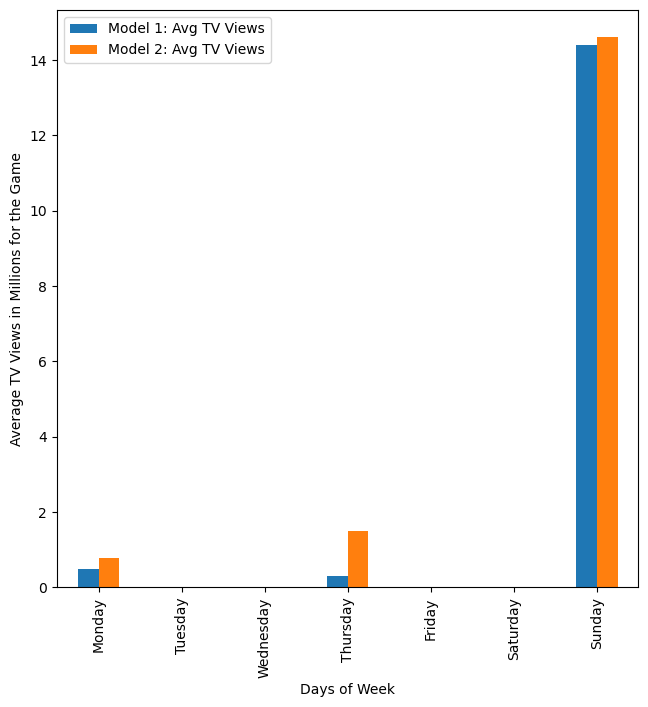

In [20]:
views_df=pd.concat([viewership_not_used_df, viewership_df], axis=1)
views_df.reset_index(inplace=True)
#creating graph to compare the viewership between Model 1 (Blue) and Model 2 (Orange)
plt.rcParams["figure.figsize"] = (7.5,7.5)
views_df.plot.bar(x='index')
plt.legend(loc='upper left')
plt.xlabel("Days of Week")
plt.ylabel("Average TV Views in Millions for the Game")
plt.show()